# Sprint Six: Image-Based Country Prediction Model

##### Owen Kroeger
##### [Video Link / Sprint Standup](https://drive.google.com/file/d/1VOQkCOf3dUmCfV3FLxLJNh7IPXHYyP5i/view?usp=sharing)

This notebook details the progress and functionality of the image-based country prediction neural network and its relationship to the GeoGuessr bot.

## Introduction
The purpose of this sprint was to develop and train a neural network capable of predicting the country of origin for an image. This model will eventually replace the reliance on external AI APIs for location predictions in the GeoGuessr bot.

By analyzing a large dataset of images labeled by country, the model learns features such as landscapes, architecture, road signs, and other visual cues. These features are used to make predictions when provided with new, unseen images.

## Dataset Overview
We utilized the **GeoLocation - Geoguessr Images (50K)** dataset from Kaggle, which contains:
- **~50,000 images** from 150+ countries.
- Images distributed in subfolders labeled by country.
- A mix of urban and rural environments.

### Dataset Preparation
1. **Data Split**:
   - Train: 70%
   - Validation: 15%
   - Test: 15%

2. **Preprocessing**:
   - Images were resized to reduce computational load.
   - Images were normalized for better model convergence.
   - The dataset was augmented with techniques like flipping and cropping.

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
DATA_DIR = "./dataset/compressed_dataset"
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes
print(f"Classes: {class_names}")

# Split into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

## Model Architecture
We fine-tuned a **ResNet-50** model pre-trained on ImageNet for this task. Key modifications included:
- Adjusting the output layer to match the number of classes (countries).
- Adding data augmentation layers to improve generalization.

The model was trained for 5 epochs on a CPU, using:
- **Cross-Entropy Loss**: To handle multi-class classification.
- **Adam Optimizer**: With a learning rate of 0.001.
- **Metrics**: Accuracy for evaluation.

In [ ]:
from torchvision.models import resnet18
import torch.nn as nn

# Load ResNet18 pre-trained on ImageNet
model = resnet18(weights="IMAGENET1K_V1")

# Replace the fully connected layer to match the number of classes
model.fc = nn.Linear(model.fc.in_features, len(class_names))

print(model)  # Displays the architecture

## Training Progress
The model was trained over several epochs with the following results:

- **Initial Accuracy**: ~1% (random guessing across 124 classes).
- **Accuracy After 5 Epochs**: ~35% (varies based on training time and dataset complexity).

In [ ]:
from tqdm import tqdm

def train_one_epoch(epoch, model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")

    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        pbar.set_postfix(Loss=running_loss / total, Accuracy=100 * correct / total)

    return running_loss / len(train_loader.dataset), 100 * correct / total

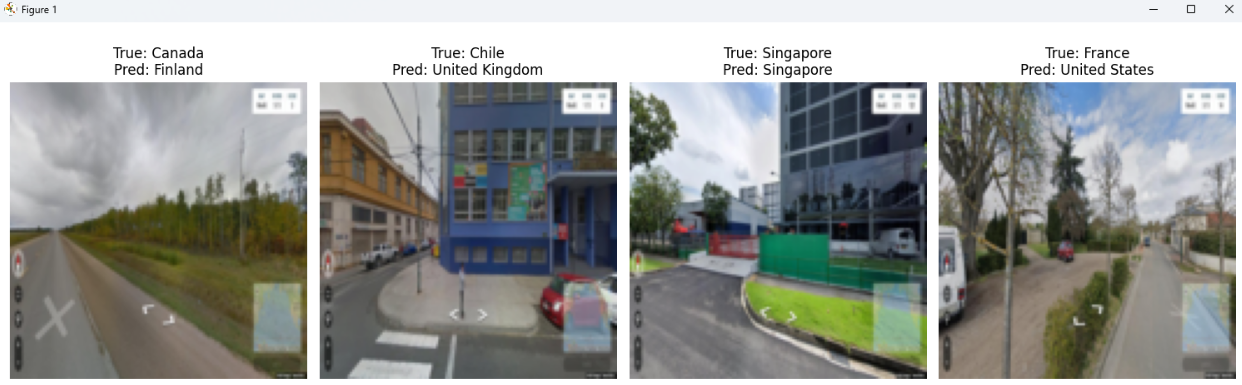

## Relationship to the GeoGuessr Bot
This model aims to replace the API calls made by the GeoGuessr bot for location predictions. Here's how the integration would work:

1. **Input**:
   - The bot takes a screenshot of the GeoGuessr game.
   - The screenshot is resized and preprocessed.

2. **Prediction**:
   - The trained model predicts the country based on the screenshot.
   - The prediction is converted into coordinates or used as a hint for guessing.

3. **Advantages**:
   - No reliance on external APIs
   - Greater customization for future improvements (e.g., finer-grained predictions).


## Challenges Encountered
- **Dataset Imbalance**: Some countries had significantly more images than others, leading to biased predictions.
- **Training Speed**: Running the model on a CPU significantly increased training time.
- **Image Complexity**: Diverse landscapes and features made it harder to generalize across countries.

### Solutions
- Applied data augmentation to underrepresented classes.
- Reduced image resolution to speed up processing.
- Increased epochs and saved checkpoints for gradual improvement.

## Next Steps
1. **Model Improvements**:
   - Incorporate additional features like text detection for road signs.
   - Use ensemble models or transformers for better predictions.

2. **Integration**:
   - Test the model with real GeoGuessr gameplay screenshots.
   - Optimize preprocessing for faster runtime.

3. **Fine-Tuning**:
   - Collect more data for underrepresented countries.
   - Explore multi-label classification for regional predictions.

4. **Deployment**:
   - Integrate the trained model into the GeoGuessr bot.
   - Create a feedback loop for continuous learning.

This sprint has laid the foundation for a self-contained AI-powered GeoGuessr bot, paving the way for more advanced functionality.